* The objective of this assignments is to build the **Decoder** part of the Transformer architecture.
* We will be using the **PyTorch** framework to implement the following components
  * Decoder Layer that contains
    * Multi-Head Masked Attention (MHMA) Module
    * Multi-Head Cross Attention (MHMA) Module
    * Position-wise Feed Forward Neural Network

  * Implement CLM

* **DO NOT** USE Built-in **TRANSFORMER LAYERS** as it affects the reproducibility.

* You will be given with a configuration file that contains information on various hyperparameters such as embedding dimension, vocabulary size,number heads and so on

* Use ReLU activation function and Stochastic Gradient Descent optimizer
* Here are a list of helpful Pytorch functions (does not mean you have to use all of them) for this subsequent assignments
  * [torch.matmul](https://pytorch.org/docs/stable/generated/torch.matmul.html#torch-matmul)
  * [torch.bmm](https://pytorch.org/docs/stable/generated/torch.bmm.html)
  * torch.swapdims
  * torch.unsqueeze
  * torch.squeeze
  * torch.argmax
  * [torch.Tensor.view](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html)
  * [torch.nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)
  * [torch.nn.Parameter](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)
  * torch.nn.Linear
  * torch.nn.LayerNorm
  * torch.nn.ModuleList
  * torch.nn.Sequential
  * [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
  
* Important: Do not set any global seeds.

* Helpful resources to get started with

 * [Andrej Karpathys Nano GPT](https://github.com/karpathy/nanoGPT)
 * [PyTorch Source code of Transformer Layer](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)



In [346]:
import torch
from torch import Tensor

import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.nn.functional import one_hot

import torch.optim as optim

from  pprint import pprint
from yaml import safe_load
import copy
import requests
from io import BytesIO

In [347]:
#do not edit this cell
config_url = "https://raw.githubusercontent.com/Arunprakash-A/LLM-from-scratch-PyTorch/main/config_files/dec_config.yml"
response = requests.get(config_url)
config = response.content.decode("utf-8")
config = safe_load(config)
pprint(config)

{'input': {'batch_size': 10, 'embed_dim': 32, 'seq_len': 8, 'vocab_size': 12},
 'model': {'d_ff': 128,
           'd_model': 32,
           'dk': 4,
           'dq': 4,
           'dv': 4,
           'n_heads': 8,
           'n_layers': 6}}


In [348]:
vocab_size = config['input']['vocab_size']
batch_size = config['input']['batch_size']
seq_len = config['input']['seq_len']
embed_dim = config['input']['embed_dim']
dmodel = embed_dim
dq = torch.tensor(config['model']['dq'])
dk = torch.tensor(config['model']['dk'])
dv = torch.tensor(config['model']['dv'])
heads = torch.tensor(config['model']['n_heads'])
d_ff = config['model']['d_ff']

# Input tokens

* Generate a raw_input ids (without any special tokens appended to it)

* Since we will be using this as label after adding the special  \<start\> token, we use the variable name "label_ids"

* Keep the size of the `label_ids=(bs,seq_len-1)` as we insert a special token ids in the next step

In [349]:
# do not edit this cell
data_url = 'https://github.com/Arunprakash-A/LLM-from-scratch-PyTorch/raw/main/config_files/w2_input_tokens'
r = requests.get(data_url)
label_ids = torch.load(BytesIO(r.content))

<ipython-input-349-8cc5628215f0>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  label_ids = torch.load(BytesIO(r.content))


* Let the first token_id be be a special `[start]` token (mapped to integer 0)
* If label_ids=$\begin{bmatrix}1&2\\3&4 \end{bmatrix}$, then we modify it as $\begin{bmatrix}0&1&2\\0&3&4 \end{bmatrix}$

In [350]:
# the first column of token_ids should be zeros and the rest of the columns come from label_ids

token_ids = torch.cat([torch.zeros((batch_size, 1), dtype=torch.long), label_ids], dim=1)

In [351]:
token_ids

tensor([[ 0,  7,  8,  7,  7,  9,  2,  6],
        [ 0, 10,  1, 10,  5,  3,  6,  8],
        [ 0,  3,  4,  8,  2, 10, 10, 10],
        [ 0,  4, 10,  1,  3,  4,  9,  7],
        [ 0,  8,  4,  7,  3,  8, 10,  5],
        [ 0,  9,  1,  8,  5,  9,  9, 10],
        [ 0,  7,  3,  8,  2,  5,  1,  5],
        [ 0,  3,  3,  2,  1,  4,  1,  1],
        [ 0, 10,  9,  9,  9,  6,  9,  2],
        [ 0,  3,  6,  6,  3,  5,  4,  5]])

# Implement the following components of a decoder layer

 * Multi-head Masked Attention (MHMA)
 * Multi-head Cross Attention (MHCA)
 * Postion-wise FFN

* Randomly initialize the parameters using normal distribution with the following seed values
  * $W_Q:$(seed=43)
  * $W_K:$(seed=44)
  * $W_V:$(seed=45)
  * $W_O:$(seed=46)

* Remember that, Multi-head cross atention takes two represnetation. One is the encoder output and the other one is the output from masked attetnion sub-layer.

* However, in this assignment, we will fix it to a random matrix.

In [352]:
class MHCA(nn.Module):

  def __init__(self,dmodel,dq,dk,dv,heads):
    super(MHCA,self).__init__()
    self.dq = dq
    self.dk = dk
    self.dv = dv
    self.heads = heads
    self.W_Q = torch.randn(size=(heads, dmodel, dq),generator=torch.random.manual_seed(43))
    self.W_K = torch.randn(size=(heads, dmodel, dq),generator=torch.random.manual_seed(44))
    self.W_V = torch.randn(size=(heads, dmodel, dq),generator=torch.random.manual_seed(45))
    self.W_O = torch.randn(size=(dmodel, dmodel),generator=torch.random.manual_seed(46))


     # your method definitions go here (if you want to)

  def forward(self, enc, x):
    """
      NOTE: enc -> Output from Encoder Layer
            x -> Output from Masked Attention Layer (in Decoder Layer)

      Dimenstions:
      x-> batch_size, seq_len, dmodel
      enc-> batch_size, seq_len, dmodel
    """
    # implement forward method
    Q = torch.einsum('bsd,hdq->bhsq',x, self.W_Q)
    K = torch.einsum('bsd,hdq->bhsq',enc, self.W_K)
    V = torch.einsum('bsd,hdq->bhsq',enc, self.W_V)

    temp_att = torch.einsum('bhsq,bhtq->bhst', Q, K)
    z = torch.softmax(temp_att, dim = -1)
    # z -> batch_size, head, seq_len (in Q), seq_len (in K)
    out = torch.einsum('bhst,bhtq->bhsq', z, V)
    out = out.permute(0, 2, 1, 3).contiguous().view(batch_size, seq_len, self.heads * self.dv)
    out = torch.einsum('bsd,od->bso', out, self.W_O)  #-> batch_size, seq_len, dmodel

    return out


* By default, `mask=None`. Therefore, create and apply the mask while computing the attention scores


In [353]:
def create_mask(batch_size, head, seq1, seq2):
  # Create a tensor of size (dim, dim) filled with negative infinity
  tensor = torch.full((batch_size, head, seq1, seq2), float('-inf'))
  # print(tensor.shape)
  # Fill the upper triangular part (including the diagonal) with zeros
  tensor = torch.triu(tensor, diagonal=0)
  # print(tensor.shape)

  # mask = torch.concat([tensor[i].fill_diagonal_(0) for i in range(batch_size)])
  # Fill the diagonal with zeros for each batch slice in-place
  for i in range(batch_size):
    for j in range(head):
      tensor[i][j].fill_diagonal_(0)
  return tensor

In [354]:
# W_Q = torch.randn(size=(heads, dmodel, dq),generator=torch.random.manual_seed(43))
# x = torch.randn(size=(batch_size, seq_len, dmodel),generator=torch.random.manual_seed(43))
# torch.einsum('bsd,hdq->bhsq', x, W_Q).shape #->10,8,8,4

# x = torch.randn(size=(batch_size, seq_len, 2),generator=torch.random.manual_seed(43))
# torch.softmax(x, dim = -1)

In [355]:
class MHMA(nn.Module):

  def __init__(self,dmodel,dq,dk,dv,heads,mask=None):
    super(MHMA,self).__init__()
    # your code goes here
    self.dq = dq
    self.dk = dk
    self.dv = dv
    self.heads = heads
    self.mask = mask
    self.W_Q = torch.randn(size=(heads, dmodel, dq),generator=torch.random.manual_seed(43))
    self.W_K = torch.randn(size=(heads, dmodel, dq),generator=torch.random.manual_seed(44))
    self.W_V = torch.randn(size=(heads, dmodel, dq),generator=torch.random.manual_seed(45))
    self.W_O = torch.randn(size=(dmodel, dmodel),generator=torch.random.manual_seed(46))



  def forward(self, x):
    # implement forward method

    # x ->  batch_size, seq_len, dmodel
    # Wq -> heads, dmodel, dq

    Q = torch.einsum('bsd,hdq->bhsq',x, self.W_Q)
    K = torch.einsum('bsd,hdq->bhsq',x, self.W_K)
    V = torch.einsum('bsd,hdq->bhsq',x, self.W_V)

    temp_att = torch.einsum('bhsq,bhtq->bhst', Q, K)
    if self.mask is None:
      self.mask = create_mask(batch_size, self.heads, temp_att.shape[2], temp_att.shape[3])
    temp_att = temp_att + self.mask
    z = torch.softmax(temp_att, dim = -1)
    # z -> batch_size, head, seq_len (in Q), seq_len (in K)
    out = torch.einsum('bhst,bhtq->bhsq', z, V)
    out = out.permute(0, 2, 1, 3).contiguous().view(batch_size, seq_len, self.heads * self.dv)
    out = torch.einsum('bsd,od->bso', out, self.W_O)  #-> batch_size, seq_len, dmodel
    return out

* Implement the FFN and OutputLayer modules (same as the one you implemented for encoder)

In [356]:
class FFN(nn.Module):
    def __init__(self, dmodel, d_ff):
        super(FFN, self).__init__()

        # First linear layer maps dmodel -> d_ff
        self.linear1 = nn.Linear(dmodel, d_ff)

        # Second linear layer maps d_ff -> dmodel
        self.linear2 = nn.Linear(d_ff, dmodel)

    def forward(self, x):
        # First linear layer followed by ReLU activation
        x = F.relu(self.linear1(x))

        # Second linear layer
        out = self.linear2(x)
        #print("Size of output from FFN layer is\n", out.size())for debugging
        return out

In [357]:
class OutputLayer(nn.Module):
    def __init__(self, dmodel, vocab_size):
        super(OutputLayer, self).__init__()

        # Linear layer mapping dmodel -> vocab_size to predict token IDs
        self.linear = nn.Linear(dmodel, vocab_size)

    def forward(self, x):
        # Apply linear layer to project to vocab size
        out = self.linear(x)
        #print("Size of output from Output layer is\n", out.size())for debugging
        return out

* Implement the final decoder layer.

In [358]:
class DecoderLayer(nn.Module):

  def __init__(self,dmodel,dq,dk,dv,d_ff,heads,mask=None):
    super(DecoderLayer,self).__init__()
    self.mhma = MHMA(dmodel,dq,dk,dv,heads,mask=None)
    self.mhca = MHCA(dmodel,dq,dk,dv,heads)
    self.layer_norm_mhma = torch.nn.LayerNorm(dmodel)
    self.layer_norm_mhca = torch.nn.LayerNorm(dmodel)
    self.layer_norm_ffn = torch.nn.LayerNorm(dmodel)
    self.ffn = FFN(dmodel,d_ff)

  def forward(self, enc_rep, x):
    mask_att = self.mhma(x)
    mask_att = self.layer_norm_mhma(mask_att + x)

    cross_att = self.mhca(enc_rep, mask_att)
    cross_att = self.layer_norm_mhca(cross_att + mask_att)

    out = self.ffn(cross_att)
    out = self.layer_norm_ffn(out + cross_att)

    return out



* Create an embedding layer that takes in token_ids and return embeddings for the token_ids

 * Use seed value: 70

In [359]:
class Embed(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(Embed, self).__init__()
        # Set the random seed for reproducibility
        torch.manual_seed(70)
        # Define the embedding layer
        self.embed = nn.Embedding(vocab_size, embed_dim)

    def forward(self, x):
        # Look up the embedding for the token IDs
        out = self.embed(x)
        return out


# Decoder

 * Implement the decoder that has `num_layers` decoder layers

In [360]:
class Decoder(nn.Module):

  def __init__(self,vocab_size,dmodel,dq,dk,dv,d_ff,heads,mask,num_layers=1):
    super(Decoder,self).__init__()
    self.embed_lookup = Embed(vocab_size, dmodel)
    self.dec_layers = DecoderLayer(dmodel,dq,dk,dv,d_ff,heads,mask)
    self.out = OutputLayer(dmodel,vocab_size)
    self.num_layers = num_layers

  def forward(self,enc_rep,tar_token_ids):
    x = self.embed_lookup(tar_token_ids)

    for i in range(self.num_layers):
      x = self.dec_layers(enc_rep,x)

    out = self.out(x)
    return out

* Representation from encoder

 * Since all the decoder layers require the representation from the encoder to compute cross attention, we are going to feed in the random values (Note, it does not require gradient during training)

In [361]:
# do not edit this
enc_rep = torch.randn(size=(batch_size,seq_len,embed_dim),generator=torch.random.manual_seed(10))

# Instantiate the model

In [362]:
model = Decoder(vocab_size,dmodel,dq,dk,dv,d_ff,heads,mask=None)

In [363]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [364]:
import matplotlib.pyplot as plt
def train(enc_rep,tar_token_ids,label_ids,epochs=1000):
  loss_trace = []
  for epoch in range(epochs):
    out = model(enc_rep,tar_token_ids)
    loss = criterion(out.view(-1,vocab_size),tar_token_ids.view(-1))
    loss_trace.append(loss.item())
    if (epoch + 1) % 100 == 0:
      print(f'Loss in epoch - {epoch + 1} is {loss.item()}')

    #backprop
    loss.backward()

    #update parameters
    optimizer.step()
    optimizer.zero_grad()
  # Plot the loss curve
  plt.plot(range(epochs), loss_trace, label='Loss in Training')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss vs. Epochs')
  plt.legend()
  plt.grid()
  plt.show()


* Train the model for 1000 epochs

In [365]:
print(token_ids)

tensor([[ 0,  7,  8,  7,  7,  9,  2,  6],
        [ 0, 10,  1, 10,  5,  3,  6,  8],
        [ 0,  3,  4,  8,  2, 10, 10, 10],
        [ 0,  4, 10,  1,  3,  4,  9,  7],
        [ 0,  8,  4,  7,  3,  8, 10,  5],
        [ 0,  9,  1,  8,  5,  9,  9, 10],
        [ 0,  7,  3,  8,  2,  5,  1,  5],
        [ 0,  3,  3,  2,  1,  4,  1,  1],
        [ 0, 10,  9,  9,  9,  6,  9,  2],
        [ 0,  3,  6,  6,  3,  5,  4,  5]])


Loss in epoch - 100 is 1.9553331136703491
Loss in epoch - 200 is 1.5987522602081299
Loss in epoch - 300 is 1.3345513343811035
Loss in epoch - 400 is 1.1080904006958008
Loss in epoch - 500 is 0.9179724454879761
Loss in epoch - 600 is 0.752234697341919
Loss in epoch - 700 is 0.6063960790634155
Loss in epoch - 800 is 0.4804282784461975
Loss in epoch - 900 is 0.3756326138973236
Loss in epoch - 1000 is 0.28967761993408203


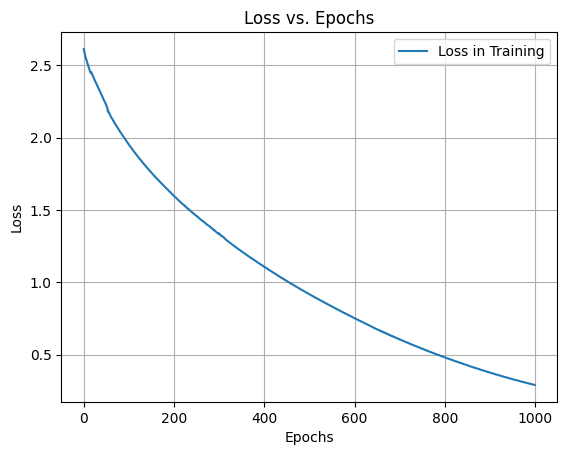

In [366]:
train(enc_rep,token_ids,label_ids,1000)

In [367]:
with torch.inference_mode():
  predictions = torch.argmax(model(enc_rep,token_ids),dim=-1)

* The loss will be around 0.17 after 1000 epochs

In [368]:
# number of correct predictions
# print(torch.count_nonzero(label_ids==predictions[:,0:-1]))

print(torch.count_nonzero(label_ids==predictions[:,1:]))

tensor(69)


* THe number of correct predictions is close to 66